## Problem 1 RRT *

## 1

Knowing point1 (to point) and point2 (base point) and maximum distance allowed for one step, the steer function is implemented as:

$$ vec = x1 - x2 $$

If norm(vec) < maximum d, scale vec to d and the coordinate of new point is calculated by (x2 + vec)

## 2

1000 iterations

![title](rrt_star_1000_v1.png)

3000 iterations

![title](rrt_star_3000_v1.png)

5000 iterations

![title](rrt_star_5000_v1.png)

10,000 iterations

![title](rrt_star_10000_v1.png)

Best cost plot every 100 iterations:

![title](best_Cost_plot.png)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import cv2
import tqdm

In [13]:
#define obstacles and map_region by [[xmin,ymin],[xmax,ymax]]
obstacles = np.array([[[4,-4],[5,9]],[[-6,-5],[0,-4]]])
#obstacles = [[[-6,-5],[0,-4]]]
map_region = [[-10,10],[10,10]]

start = np.array([0.0,0.0])
target = np.array([8.0,8.0])

In [14]:
def distance(x1, x2):
    
    vec = x1 - x2
    distance = np.linalg.norm(vec)
    return distance


In [15]:
class Node():
    
    def __init__(self, pos):
        self.pos = pos
        self.cost = 0
        self.parent = None
        

In [16]:

class RRTstar():
    
    def __init__(self, start, target, obstacles, map_region, expand_r ,max_iter):
        
        self.start = Node(start)
        self.target = Node(target)
        
        self.expand_r = expand_r
        self.map_region = map_region # list of [[xmin, ymin],[xmax, ymax]]
        self.obstacles = obstacles # list of [[xmin, ymin],[xmax, ymax]]
        self.max_iter = max_iter
        
        self.nodes = []
        self.nodes.append(self.start)
        self.distance = None
        self.final_state = None
        self.best_cost_list = []
        
    def rrt_star_search(self):
        
        dim = 2
        gamma = 1.4
        final_node = None
        
        for i in range(self.max_iter):
            
            self.distance = np.zeros(len(self.nodes))
            
            rnd_node = self.sample() #sample free
            nearest_v = self.find_nearest(self.nodes, rnd_node) #find nearest node, #update self.distance
            
            #steer
            
            vec = self.steer(rnd_node, nearest_v)
            
            new_pt = nearest_v.pos + vec
            new_node = Node(new_pt)
            
            if not self.isCollisionFree(new_node, nearest_v,self.obstacles,0.6):
                continue
            # nodes for reconnect
            #radius = min((gamma * np.log(i+1)/(i+1))**(1/dim),3.142 * (self.expand_r)**(1/dim))
            radius = min(np.power(gamma * np.log(len(self.nodes))/len(self.nodes),1/dim),self.expand_r)
            _near_nodes = self.nearest(new_pt, radius)
            
            d = distance(nearest_v.pos, new_pt)
            
            #cost and parent for update
            cost_min = nearest_v.cost + d
            mini_cost_node = nearest_v
            
            new_node.cost = cost_min
            new_node.parent = mini_cost_node
            
            if len(_near_nodes) > 0:
                
                for node in _near_nodes:

                    d = distance(node.pos, new_pt)
                    cost_temp = d + node.cost

                    if self.isCollisionFree(node, new_node,self.obstacles,0.6) and cost_temp < new_node.cost:
                        new_node.cost = cost_temp
                        new_node.parent = node  
                    #print("rewired")
                        
                for node in _near_nodes:
                    d = distance(node.pos, new_pt)
                    cost_temp= d + new_node.cost

                    if self.isCollisionFree(node,new_node,self.obstacles,0.6) and cost_temp < node.cost:
                        node.cost = cost_temp
                        node.parent = new_node
                    #print("reconnect")

            self.nodes.append(new_node)
            
            if distance(new_pt, self.target.pos) < 0.5 + 0.6:
                
                if final_node == None:
                    final_node = new_node
                if final_node.cost > new_node.cost:
                    final_node = new_node
                    
            if final_node != None and i%100 == 0:
                self.best_cost_list.append(final_node.cost)
                
                    
        if final_node == None:
            print ('has not gotten to final state')
        else:
            self.final_state = final_node
            
        return self.nodes, self.final_state
    
    def plotmap(self):
        
        domain = self.map_region
        obstacles = self.obstacles
        start_pos = self.start.pos
        target_pos = self.target.pos
        
        fig = plt.figure()
        ax = fig.add_subplot(111, aspect = "equal")
    
        ax.axis([-10,10,-10,10])
    
        sitemap = patches.Rectangle(domain[0], 20,20, linewidth = 1,facecolor = "none")
        ax.add_patch(sitemap)

        for val in obstacles:
            obstacle = patches.Rectangle(val[0], abs(val[0][0] - val[1][0]), abs(val[1][1] - val[0][1]), facecolor ="darkgrey")
            ax.add_patch(obstacle)

        start_circle = patches.Circle(start_pos, 0.6,facecolor ="b")
        target_circle = patches.Circle(target_pos, 0.5,facecolor = "g")
        
        for node in self.nodes:
            if node.parent != None:
                parent = node.parent
                ax.plot([node.pos[0], parent.pos[0]],[node.pos[1], parent.pos[1]],color ="deepskyblue")
                
        if self.final_state != None:
            isStart = False
            node_1 = self.final_state
            node_2 = node_1.parent

            end_patch = patches.Circle(node_1.pos, 0.6,facecolor = "aqua")
            ax.add_patch(end_patch)

            while isStart == False:

                ax.plot([node_1.pos[0], node_2.pos[0]],[node_1.pos[1], node_2.pos[1]],color ="r")
                node_1 = node_2
                node_2 = node_1.parent
                if node_2 != None:
                    isStart = False
                else:
                    isStart = True
                    
        ax.add_patch(start_circle)
        ax.add_patch(target_circle)
                
        plt.show()
                         
    def sample(self):
        
        new_pt = np.random.rand(2)
        new_pt = new_pt * 20 - 10      
        new_pt = Node(new_pt) 
        
        return new_pt
    
    def find_nearest(self, nodes, node):
                
        for i in range(len(nodes)):
            
            d = distance(nodes[i].pos, node.pos)
            self.distance[i] = d
            
        nearest_ind =  np.argmin(self.distance)
        nearest_node = nodes[nearest_ind]
        
        return nearest_node        
        
    def steer(self, node1, node2):
        #node 1: to point  node 2: base point
        
        x1 = node1.pos
        x2=  node2.pos
        vec = x1 - x2 
        
        if distance(x1,x2)< self.expand_r:
            
            vec = x1 - x2 
        else:
            vec = (x1 - x2) / distance(x1,x2) * self.expand_r
        
        return vec
        
    def nearest(self,node,radius):
        
        near_nodes = []
        
        for i in range(len(self.distance)):
            d = self.distance[i]
            node = self.nodes[i]
            if d/20 < radius:
                near_nodes.append(node)
            
        return near_nodes  
        
    def isCollisionFree(self, node1, node2, obstacles,margin):
        
        #detect collision 
       
        indicator = []
        pt1 = node1.pos
        pt2 = node2.pos
        pt1 = np.append(pt1,1)  
        pt2 = np.append(pt2,1)   
        ln = np.cross(pt1,pt2)

        for obstacle in obstacles:
            lower_bound = obstacle[0] - np.array([margin, margin])
            upper_bound = obstacle[1] + np.array([margin, margin])
            x_delta = abs(lower_bound[0] - upper_bound[0])
            y_delta = abs(lower_bound[1] - upper_bound[1])
            pt_ll = lower_bound
            pt_ur = upper_bound
            pt_lr = lower_bound + np.array([x_delta,0])
            pt_ul = lower_bound + np.array([0,y_delta])

            l_pts = [[pt_ll, pt_lr],[pt_ll,pt_ul],[pt_ur,pt_ul],[pt_ur,pt_lr]]

            for l_pt in l_pts:

                l_pt1 = np.append(l_pt[0],1)
                l_pt2 = np.append(l_pt[1],1)
                line = np.cross(l_pt1,l_pt2)
                pt_intersect = np.cross(ln, line)

                if pt_intersect[2] == 0:
                    indicator.append(False)

                else:
                    pt_intersect = pt_intersect/pt_intersect[2]
                    vec1_pt = pt_intersect - pt1
                    vec2_pt= pt_intersect - pt2
                    vec1_l = pt_intersect - l_pt1
                    vec2_l= pt_intersect - l_pt2
                    
                    sc1 = np.dot(vec1_pt, vec2_pt)
                    sc2 = np.dot(vec1_l, vec2_l)
                    if sc1 < 0 and sc2 < 0:
                        indicator.append(True)
                    else:
                        indicator.append(False)
                        
        if np.sum(indicator) == 0:
            
            return True
            

In [17]:
rrt_planner = RRTstar(start, target, obstacles, map_region,1,10000)

In [18]:
nodes = rrt_planner.rrt_star_search()

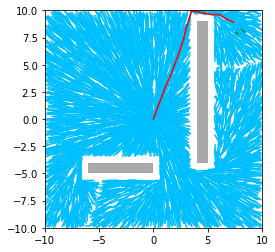

In [19]:
rrt_planner.plotmap()

## 3. Cost Plot

Text(0.5,1,'Best Cost every 100 iterations')

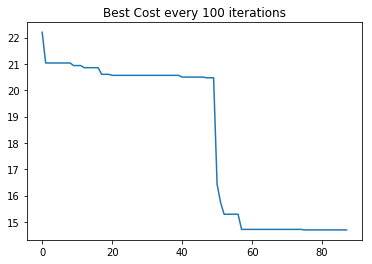

In [21]:
plt.plot(rrt_planner.best_cost_list)
plt.title("Best Cost every 100 iterations")